# Heritability and Genetic Correlation

https://github.com/bulik/ldsc/wiki/Heritability-and-Genetic-Correlation

In [19]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
from basic_tools import eps_selected, eps_dict
from statsmodels.stats import multitest
from matplotlib.ticker import ScalarFormatter
import warnings
warnings.filterwarnings('ignore')

In [7]:
# data_dir = os.getcwd()+'/data/'
# res_dir = os.getcwd()+'/res/'
res_dir = '/Users/feiwang/Documents/Materials/familial_trajectory/'

In [8]:
eps = ['T1D_STRICT', 'M13_RHEUMA', 'M13_SJOGREN', 'M13_SYSTSLCE', 'M13_WEGENER', 'M13_MCTD', 'SLE_FG', 'N14_IGA_NEPHROPATHY', 'CHIRBIL_PRIM',
       'G6_MS', 'G6_DISSOTH', 'G6_MYASTHENIA', 'G6_OTHDEMYEL', 'G6_MYOMUSCINOTH', 'G6_GUILBAR', 'H7_IRIDOCYC_ANTER',
        #  'M13_DERMATOPOLY', 'I9_RHEUFEV', 'E4_GRAVES_OPHT_STRICT', 'L12_PEMPHIGOID',
       'AUTOIMMUNE_HYPERTHYROIDISM', 'E4_THYROIDITAUTOIM', 'E4_HYTHY_AI_STRICT', 'E4_ADDISON', 'D3_AIHA_OTHER', 'D3_ITP', 'D3_ANAEMIA_B12_DEF', 'D3_ALLERGPURPURA',
       'J10_ASTHMACOPDKELA', 'K11_CROHN', 'K11_COELIAC', 'K11_IBD', 'L12_PSORIASIS', 'L12_VITILIGO', 'L12_ALOPECAREATA', 'L12_DERMATHERP', 'T2D', 'GEST_DIABETES']

## 1. Process data for LDSC
check if ref allele and alt allele are on the same direction.

### if good summary stats can be found from GWAS Catalog:
https://www.ebi.ac.uk/gwas/

In [53]:
# Choose the summary stats by the effect size. The bigger, the better.
# formula: ((4 * n_cases * n_controls)/(n_cases + n_controls))

ep = 'SLE_FG'
# 'T1D_STRICT', 'K11_COELIAC', 'SLE_FG', 'M13_RHEUMA', 'T2D', 'L12_VITILIGO'
# 'G6_MYASTHENIA', 'J10_ASTHMA', 'G6_MS', 'L12_PSORIASIS'

file_in = res_dir+'data/'+ep+'.txt' # tsv txt
# file_in = res_dir+'data/'+ep+'_meta_out.tsv.gz'
file_out = res_dir+'processed_stats_/'+ep+'.premunge.gz'
if not os.path.isfile(file_in):
    file_in = res_dir+'data/'+ep+'.tsv'
if not os.path.isfile(file_in):
    file_in = res_dir+'data/'+ep+'.csv'
if not os.path.isfile(file_in):
    print('Data cannot be found!')
df = pd.read_csv(file_in, sep='\t')
if len(df.columns) == 1:
    df = pd.read_csv(file_in, sep=' ')
if len(df.columns) == 1:
    df = pd.read_csv(file_in)
#     try:
#         df = pd.read_csv(file_in, sep=' ')
#     except pd.errors.ParserError:
#         df = pd.read_csv(file_in)
df = df.rename(columns={
    'rsid': 'snpid', 'SNPID': 'snpid', 'variant_id': 'snpid', 'SNP': 'snpid',
    'effect_allele': 'a1', 'A1': 'a1', 'A1_effect': 'a1',
    'other_allele': 'a2', 'A2': 'a2', 'A2_other': 'a2',
    'p': 'pval', 'P-val': 'pval', 'p_value': 'pval', 'P_EUR': 'pval',
    'OR(A1)': 'or', 'odds_ratio': 'or',
    'standard_error': 'se', 'se_EUR': 'se',
    'beta_EUR': 'beta'
})
print(len(df))
df.head(3)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


7915251


,chrom,pos,snpid,a2,a1,pval,beta,se,OR,OR_lower,OR_upper
0,1,768253,rs2977608,C,A,0.623366,0.019803,0.040324,1.02,0.942487,1.103888
1,1,781845,rs61768199,A,G,0.889415,0.009950,0.071562,1.01,0.877822,1.162081
2,1,787606,rs3863622,G,T,0.864496,-0.010050,0.058893,0.99,0.882073,1.111133


### if RSID is not in the summary stats:

In [71]:
Infile=res_dir+'data/'+"L12_PSORIASIS.tsv"
OutFile=res_dir+'data/'+"L12_PSORIASIS_TEST.tsv"
HM3ref=res_dir+'data/'+"HM3Ref"
build=res_dir+'data/'+"hg37"

In [73]:
df = pd.read_table(Infile, low_memory=False)
df['hg37'] = 'chr'+df.chromosome.astype(str)+':'+df.base_pair_location.astype(str)
df['A1'] = df.effect_allele.str.upper()
df['A2'] = df.other_allele.str.upper()
Ref = pd.read_table(HM3ref)
ref = Ref.rename(columns={'REF': 'A1', 'ALT': 'A2'})
tmp1 = pd.merge(df, ref, how = 'inner', on = [build, 'A1', 'A2'])
tmp1 = tmp1.drop(['hg36', 'hg37', 'hg38'], axis=1)
ref = Ref.rename(columns={'REF': 'A2', 'ALT': 'A1'})
tmp2 = pd.merge(df, ref, how = 'inner', on = [build, 'A1', 'A2'])
tmp2 = tmp2.drop(['hg36', 'hg37', 'hg38'], axis=1)
tmp = pd.concat([tmp1, tmp2])
tmp.to_csv(OutFile, sep = '\t', index = None)

In [142]:
# All SNPs on chromosome 23 have been removed from the list
Ref['chr'] = Ref.hg38.str.extract('chr(\d+)\:')
Ref[Ref.chr=='23']

,SNP,hg36,hg37,hg38,REF,ALT,chr


### if an endpoint has sub dataset for each chromosome:

In [72]:
df = pd.read_csv(data_dir+'/vitiligo/GWAS123chrXcmh.txt', sep='\t')
for i in tqdm.tqdm(range(1, 23)):
    df_ = pd.read_csv(data_dir+'/vitiligo/GWAS123chr'+str(i)+'cmh.txt', sep='\t')
    df_ = df_.rename(columns={'CMH P':'P', 'ORX':'OR'})
    df = pd.concat([df, df_], axis=0)
df['snpid'] = df.SNP.str.lower()
df = df.rename(columns={'A1': 'a1', 'A2': 'a2', 'P': 'p', 'OR': 'or', 'SE': 'se'})
df = df[['a1', 'a2', 'p', 'or', 'se', 'snpid']]
df.to_csv(data_dir+'/autoimmune_gwas_sumstats/L12_VITILIGO.txt', index=None)

100%|██████████| 22/22 [00:26<00:00,  1.21s/it]


### if the format of the summary stats has a problem:
the number of the cols in some rows are larger than the number of the header

In [ ]:
# 'K11_IBD', 'K11_CROHN', 'M13_SJOGREN' finn, 'M13_SYSTSLCE' 格式, 'G6_MS'

ep = 'K11_CROHN'
file_in = data_dir+ep+'.txt'
file_out = data_dir+ep+'.premunge.gz'
matrix = []
with open(file_in) as f:
    for line in f:
        row = line.split(' ')
        if len(row) != 8:
            row = row[:7] + [row[-1]]
        matrix.append(row)
matrix = np.array(matrix)
df = pd.DataFrame(matrix[1:], columns=matrix[0])
df['snpid'] = df['SNP\n'].str[:-1]
df = df.rename(columns={
    'Allele1': 'a1',
    'Allele2': 'a2',
    'P.value': 'pval',
    'Effect': 'beta'
})
df['beta'] = df.beta.astype(float)
df['pval'] = df.pval.astype(float)
print(len(df))
df.head(3)


In [ ]:
# find out which paper using this data by searching the newly found loci in the paper
rsid = 'rs80244186'
a=df[df.snpid == rsid]
print('or: ', round(np.exp(a.iloc[0,-1]), 2))
print('p:  ', a.iloc[0,-2])

### if summary stats can be find from Finngen results:
1. to download data from Finngen + UKBB:
- https://finngen.gitbook.io/finngen-analyst-handbook/finngen-data-specifics/green-library-data-aggregate-data/other-analyses-available/meta-analysis-finngen-ukbb-estbbuntitled
- gsutil cp gs://finngen-production-library-green/finngen_R9/finngen_R9_analysis_data/ukbb_meta/meta/G6_MS_meta_out.tsv.gz /Users/feiwang/Documents/Materials/familial_trajectory/data

In [12]:
# L12_ALOPECAREATA, N14_IGA_NEPHROPATHY, GEST_DIABETES, G6_OTHDEMYEL, E4_THYROIDITAUTOIM,
# E4_HYTHY_AI_STRICT, D3_ANAEMIA_B12_DEF, CHIRBIL_PRIM, AUTOIMMUNE_HYPERTHYROIDISM, M13_SJOGREN

ep = 'G6_MS'
file_in = res_dir+'data/'+ep+'_meta_out.tsv.gz'
file_out = res_dir+'processed_stats/'+ep+'.premunge.gz'
df = pd.read_csv(file_in, sep='\t')
df = df.rename(columns={
    'rsid': 'snpid',
    'REF': 'a1',
    'ALT': 'a2',
    'all_inv_var_meta_p': 'pval',
    'all_inv_var_meta_beta': 'beta'
})
print(len(df))
df.head(3)

31609392


,#CHR,POS,a1,a2,SNP,FINNGEN_beta,FINNGEN_sebeta,FINNGEN_pval,FINNGEN_af_alt,FINNGEN_af_alt_cases,...,UKBB_sebeta,UKBB_pval,UKBB_af_alt,all_meta_N,beta,all_inv_var_meta_sebeta,pval,all_inv_var_meta_mlogp,all_inv_var_het_p,snpid
0,1,11063,T,G,1:11063:T:G,NaN,NaN,NaN,NaN,NaN,...,11.20,0.964,0.000048,1,0.5070,11.200,0.964,0.0160,NaN,rs561109771
1,1,13259,G,A,1:13259:G:A,NaN,NaN,NaN,NaN,NaN,...,1.18,0.357,0.000277,1,-1.0900,1.180,0.357,0.4480,NaN,rs562993331
2,1,13668,G,A,1:13668:G:A,-0.0952,0.377,0.801,0.00585,0.005619,...,NaN,NaN,NaN,1,-0.0952,0.377,0.801,0.0964,NaN,rs2691328


2. to download data from Finngen if the endpoint cannot be found from Finngen + UKBB:
- gsutil cp gs://finngen-production-library-green/finngen_R9/finngen_R9_analysis_data/summary_stats/release/finngen_R9_M13_RHEUMA.gz /Users/feiwang/Documents/Materials/familial_trajectory/data

In [14]:
# D3_AIHA_OTHER, D3_ALLERGPURPURA, D3_ITP, E4_ADDISON, G6_DISSOTH, G6_GUILBAR,
# H7_IRIDOCYC_ANTER, L12_DERMATHERP, M13_MCTD, M13_WEGENER

ep = 'K11_COELIAC'
file_in = res_dir+'data/finngen_R9_'+ep+'.gz'
file_out = res_dir+'processed_stats/'+ep+'.premunge.gz'
df = pd.read_csv(file_in, sep='\t')
df = df.rename(columns={
    'rsids': 'snpid',
    'ref': 'a1',
    'alt': 'a2',
})
print(len(df))
df.head(3)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


20169895


,#chrom,pos,a1,a2,snpid,nearest_genes,pval,mlogp,beta,sebeta,af_alt,af_alt_cases,af_alt_controls
0,1,13668,G,A,rs2691328,OR4F5,0.985537,0.006327,0.005249,0.289541,0.005855,0.005870,0.005854
1,1,14773,C,T,rs878915777,OR4F5,0.373047,0.428237,-0.160684,0.180386,0.013500,0.012807,0.013507
2,1,15585,G,A,rs533630043,OR4F5,0.012429,1.905560,1.409850,0.564001,0.001103,0.001675,0.001097


### save the data as a pre-munge file

In [52]:
# if the data above looks all good, save it as a zipped tsv
df = df[['snpid', 'A2', 'A1', 'pval', 'beta']]
df.to_csv(file_out, sep='\t', compression='gzip', index=None)

In [50]:
df = df.rename(columns={'a1':'A2', 'a2':'A1'})
df.head(3)

,snpid,pval,chromosome,base_pair_location,A2,A1,effect_allele_frequency,beta,se,sample_size
0,rs367896724,0.284,1,10177,AC,A,0.39800,0.059058,0.055112,363495
1,rs555500075,0.731,1,10352,TA,T,0.39300,0.019496,0.056730,363495
2,rs534229142,0.844,1,10511,A,G,0.00131,-0.148768,0.756536,363495


## 2. Munge the data and apply LDSC in terminal
- In terminal, run code below:
<code>
    cd Projects/familial_trajectory/ldsc
    source activate ldsc
    ep1=T1D_STRICT
    ep2=K11_IBD
    python munge_sumstats.py \
        --sumstats data/$ep2.premunge.gz \
        --N-cas 2051 \
        --N-con 594747 \
        --out data/$ep2 \
        --merge-alleles w_hm3.snplist \
        --chunksize 500000
    python ldsc.py \
        --rg data/$ep1.sumstats.gz,data/$ep2.sumstats.gz \
        --ref-ld-chr eur_w_ld_chr/ \
        --w-ld-chr eur_w_ld_chr/ \
        --out res/$ep1.$ep2
</code>

## 3. Extract the results from log files and merge the information
https://academic.oup.com/bioinformatics/article/33/2/272/2525718
- Heritability (H2) Z score is at least > 1.5 (optimal > 4)
- Mean Chi square of the test statistics > 1.02
- The intercept estimated from the SNP heritability analysis is between 0.9 and 1.1

In [17]:
header1 = ['mean chi2_1', 'b_1', 'mean chi2_2', 'b_2']
header2 = ['ep1', 'ep2', 'rg', 'se','z', 'p', 'h2_obs', 'h2_obs_se', 'h2_int', 'h2_int_se', 'gcov_int', 'gcov_int_se']

def findStats(string):
    stats1 = re.findall(r'data/([\w_\d]+)\.sumstats\.gz', string)
    stats2 = re.findall(r'\s+([-]{0,1}\d+\.\d+(e\-\d+){0,1})', string)
    if len(stats2) != 10:
        print(string)
    stats2 = [float("{:.4f}".format(float(i[0]))) for i in stats2]
    stat_dict = dict(zip(header2, stats1+stats2))
    return stat_dict

def readLog(log_file, df):
    with open(log_file) as f:
        log = f.readlines()
    if len(log) != 0:
        findings1 = []
        for line in log:
            if re.match(r'^Mean Chi\^2\: ', line): 
                findings1.append(re.findall(r'^Mean Chi\^2\: (.+)$', line)[0])
            if re.match(r'^Intercept\: ', line): 
                findings1.append(re.findall(r'^Intercept\: (.+) \(\d', line)[0])
            if re.match(r'^data/', line):
                findings2 = findStats(line)
        findings1 = dict(zip(header1, findings1))
        df = df.append(pd.Series({**findings1, **findings2}), ignore_index=True)
    return df

In [33]:
ep1 = 'T1D_STRICT'
stat_df = pd.DataFrame(columns=header1+header2, dtype=object)
for ep2 in eps[1:]:
    f_name = res_dir+'ldsc_res/'+ep1+'.'+ep2+'.log'
    if os.path.isfile(f_name):
        stat_df = readLog(f_name, stat_df)
    else:
        print(ep2)
stat_df = stat_df.sort_values(by='h2_obs')
stat_df['fdr_ldsc'], _ = multitest.fdrcorrection(stat_df.p)

G6_MYOMUSCINOTH


### 3.1 Analysis without chromosome 6
Removal of HLA region in LDSC https://groups.google.com/g/ldsc_users/c/fEDtVvcm5oc

In [75]:
# analysis without chromosome 6
hm3 = pd.read_table(res_dir+'w_hm3.snplist')
hm3 = hm3.merge(Ref[['SNP','hg38']], 'left', on='SNP')
hm3['chr'] = hm3.hg38.str.extract('^(chr\d+):')
hm3_without6 = hm3[hm3.chr != 'chr6']
hm3_without6.to_csv(res_dir+'hm3_without6.csv', index=None)

In [124]:
ep = 'M13_RHEUMA'
file_in = res_dir+'processed_stats_/'+ep+'.premunge.gz'
file_out = res_dir+'processed_stats_without6/'+ep+'.premunge.gz'
df = pd.read_csv(file_in, sep='\t')
print(len(df))
df.head(3)

129273


,snpid,a2,a1,pval,beta,se
0,rs61733845,G,A,0.3552,0.039797,0.043045
1,rs1320571,G,A,0.9195,-0.004309,0.042639
2,rs9729550,A,C,0.1089,0.037970,0.023684


In [125]:
df = df[df.snpid.isin(hm3_without6.SNP)]
print(len(df))
df.to_csv(file_out, sep='\t', compression='gzip', index=None)

In [146]:
res_without6 = [
    'data/T1D_STRICT.sumstats.gz  data/M13_RHEUMA.sumstats.gz 0.5217  0.1173 4.4488  8.6334e-06   0.815     0.2718  1.1445     0.0642    0.173       0.0663',
    'data/T1D_STRICT.sumstats.gz  data/L12_DERMATHERP.sumstats.gz  0.4335  0.312  1.3895  0.1647   0.001     0.0012  1.0086     0.0073    0.0032       0.0051',
    'data/T1D_STRICT.sumstats.gz  data/AUTOIMMUNE_HYPERTHYROIDISM.sumstats.gz  0.4749  0.0929  5.1124  3.1812e-07  0.0047     0.0009  1.0076     0.0071    0.0024       0.0064',
    'data/T1D_STRICT.sumstats.gz  data/D3_ANAEMIA_B12_DEF.sumstats.gz  0.5353  0.0958  5.5863  2.3189e-08   0.004     0.0008  1.0294     0.0078    0.0111       0.0075',
    'data/T1D_STRICT.sumstats.gz  data/K11_COELIAC.sumstats.gz 0.252  0.0729 3.4578  0.0005  0.2432     0.0483  1.0626     0.0087   0.1115       0.0067',
    'data/T1D_STRICT.sumstats.gz  data/E4_HYTHY_AI_STRICT.sumstats.gz  0.4592  0.0435  10.5483  5.1703e-26  0.0626     0.0072  1.1368     0.0286    0.0258       0.0119'
]
stat_df_without6 = pd.DataFrame(columns=header2, dtype=object)
for i in res_without6:
    stat_df_without6 = stat_df_without6.append(pd.Series(findStats(i)), ignore_index=True)
    
stat_compare = stat_df_without6[['ep1', 'ep2', 'rg', 'p']].rename(columns={'rg':'rg_w/o6', 'p':'p_w/o6'})
stat_compare = stat_compare.merge(stat_df[['ep2','rg','p']].rename(columns={'rg':'rg_w6', 'p':'p_w6'}), 'left', on='ep2')
stat_compare = stat_compare[['ep1', 'ep2', 'rg_w/o6', 'rg_w6', 'p_w/o6', 'p_w6']]

In [232]:
stat_compare

,ep1,ep2,rg_w/o6,rg_w6,p_w/o6,p_w6
0,T1D_STRICT,M13_RHEUMA,0.5217,0.5199,0.0000,0.0010
1,T1D_STRICT,L12_DERMATHERP,0.4335,0.4599,0.1647,0.1373
2,T1D_STRICT,AUTOIMMUNE_HYPERTHYROIDISM,0.4749,0.4782,0.0000,0.0000
3,T1D_STRICT,D3_ANAEMIA_B12_DEF,0.5353,0.5008,0.0000,0.0000
4,T1D_STRICT,K11_COELIAC,0.2520,0.2726,0.0005,0.0002
5,T1D_STRICT,E4_HYTHY_AI_STRICT,0.4592,0.4505,0.0000,0.0000


## 4. convert h2 from observed scale to liability scale
- https://gist.github.com/nievergeltlab/fb8a20feded72030907a9b4e81d1c6ea
- https://www.sciencedirect.com/science/article/pii/S0002929711000206?via%3Dihub

In [17]:
# Method 1:
import json
with open('/Users/feiwang/Documents/Projects/stats__2021-03-25.json') as f:
    stats = json.load(f)
stat_df['prevalence'] = [stats['stats'][i]['prevalence_all'] for i in stat_df.ep2]

In [388]:
# prevalence of T1D in FinRegistry
stats['stats']['T1D_STRICT']['prevalence_all']

0.0099073834

In [40]:
# Method 2:
stats = pd.read_excel(res_dir+'summary_of_ADs.xlsx', sheet_name='summary')[['Endpoint', 'Prevalence', 'case', 'control']]
stat_df = stat_df.merge(stats.rename(columns={'Endpoint':'ep2', 'Prevalence':'prevalence'}), 'left', on='ep2') 
stat_df['prevalence'] = stat_df['prevalence']*0.01

h2_liab <- h2 * K^2 * ( 1 - K)^2 / P / (1-P) / zv^2

var_h2_liab <- ( seh2 * K^2 * ( 1 - K)^2 / P / (1-P) / zv^2) ^2

In [42]:
stat_df['z_pdf'] = norm.pdf(norm.ppf(1-stat_df['prevalence']))
stat_df['proportion'] = stat_df.case / stat_df.control
stat_df['h2_lia'] = stat_df.h2_obs*(stat_df.prevalence**2)*(1-stat_df.prevalence)**2/stat_df.proportion/(1-stat_df.proportion)/(stat_df.z_pdf**2)
stat_df['se_lia'] = stat_df.h2_obs_se*(stat_df.prevalence**2)*(1-stat_df.prevalence)**2/stat_df.proportion/(1-stat_df.proportion)/(stat_df.z_pdf**2)

In [92]:
from scipy.stats import chi2
chi2.cdf(1-(0.021359**2)/(0.046990**2), 1)

0.6269230284025792

In [34]:
stat_df['rg_025'] = stat_df.rg - 1.96*stat_df.se
stat_df['rg_975'] = stat_df.rg + 1.96*stat_df.se

In [44]:
stat_df.sort_values('ep2')

,mean chi2_1,b_1,mean chi2_2,b_2,ep1,ep2,rg,se,z,p,...,fdr_ldsc,rg_025,rg_975,prevalence,case,control,z_pdf,proportion,h2_lia,se_lia
17,1.3861,1.0711,1.0663,1.0112,T1D_STRICT,AUTOIMMUNE_HYPERTHYROIDISM,0.4782,0.0915,5.2252,0.0000,...,True,0.298860,0.657540,0.0034,2051.0,594747.0,0.010240,0.003449,0.149752,0.028676
14,1.1481,1.0507,1.05,1.0151,T1D_STRICT,CHIRBIL_PRIM,0.3603,0.1245,2.8935,0.0038,...,True,0.116280,0.604320,0.0009,871.0,689529.0,0.003057,0.001263,0.178361,0.048020
2,1.3856,1.072,0.9975,0.9919,T1D_STRICT,D3_AIHA_OTHER,0.3866,0.3571,1.0828,0.2789,...,False,-0.313316,1.086516,0.0004,280.0,376439.0,0.001445,0.000744,0.082396,0.113295
0,1.3856,1.072,0.9939,0.9899,T1D_STRICT,D3_ALLERGPURPURA,0.2954,0.3961,0.7456,0.4559,...,False,-0.480956,1.071756,0.0019,856.0,371504.0,0.006052,0.002304,0.021359,0.046990
16,1.3861,1.0711,1.0926,1.0266,T1D_STRICT,D3_ANAEMIA_B12_DEF,0.5008,0.0911,5.4963,0.0000,...,True,0.322244,0.679356,0.0064,4463.0,756893.0,0.018003,0.005896,0.093652,0.017028
4,1.3856,1.072,1.0088,0.9998,T1D_STRICT,D3_ITP,0.1687,0.1757,0.9601,0.3370,...,False,-0.175672,0.513072,0.0014,810.0,371504.0,0.004582,0.002180,0.051352,0.051352
6,1.3856,1.072,1.0178,1.0061,T1D_STRICT,E4_ADDISON,0.0303,0.1536,0.1970,0.8439,...,False,-0.270756,0.331356,0.0011,923.0,361988.0,0.003675,0.002550,0.056249,0.045702
23,1.3861,1.0712,2.0365,1.153,T1D_STRICT,E4_HYTHY_AI_STRICT,0.4505,0.0487,9.2486,0.0000,...,True,0.355048,0.545952,0.1076,67892.0,644381.0,0.185077,0.105360,0.176484,0.017706
8,1.3861,1.0711,1.0251,1.0002,T1D_STRICT,E4_THYROIDITAUTOIM,0.3088,0.1345,2.2966,0.0216,...,True,0.045180,0.572420,0.0012,738.0,719737.0,0.003980,0.001025,0.150546,0.061989
9,1.3856,1.072,1.0114,0.9993,T1D_STRICT,G6_DISSOTH,0.1330,0.1317,1.0098,0.3126,...,False,-0.125132,0.391132,0.0004,277.0,374678.0,0.001445,0.000739,0.176160,0.113986


## 5. Visualize the final results

In [237]:
def plot_odds_ratio(df, note_who, outcome='T1D_STRICT', plt_len=15):
    """
    :param results: a DataFrame of summary statistics
    :param outcome: a string which indicates the outcome disease name
    :return: a odds ratio plot of all the diseases in the list
    """
    df = df[(df.note == note_who[0]) & (df.who == note_who[1])]
    df = df.sort_values(by='endpoint')
    df.index = range(len(df))
    plt.figure(figsize=(plt_len, 5))
    plt.box(False)
    plt.grid()
    sig_eps = []
    for i, row in df.iterrows():
        alpha = 1 if row.pval <= 0.05 / len(df) else 0.12
        if alpha == 1:
            sig_eps.append(row.endpoint)
        plt.plot((i, i), (row.hr_025, row.hr_975), color='green', alpha=alpha)
        plt.plot(i, (row.hr_025+row.hr_975)/2, 's', color='green', alpha=alpha)

    plt.xticks(range(len(df)), [eps_dict[i] for i in df.endpoint.tolist()], rotation=90)
    
    plt.yscale('log')
    plt.yticks([.7, 1, 2, 3, 4, 5, 6, 7])
    ax = plt.gca()
    ax.get_yaxis().set_major_formatter(ScalarFormatter())
    
    plt.ylabel('odds ratio', size=12)
    plt.axhline(y=1.0, color='black', linestyle='--', linewidth=1)
    plt.axhline(y=3.0, color='black', linestyle='--', linewidth=1, alpha=0.1)
    plt.axhline(y=5.0, color='black', linestyle='--', linewidth=1, alpha=0.1)
    plt.axhline(y=0.7, color='black', linestyle='--', linewidth=1, alpha=0.1)
    plt.grid()
    plt.show()
    return sig_eps

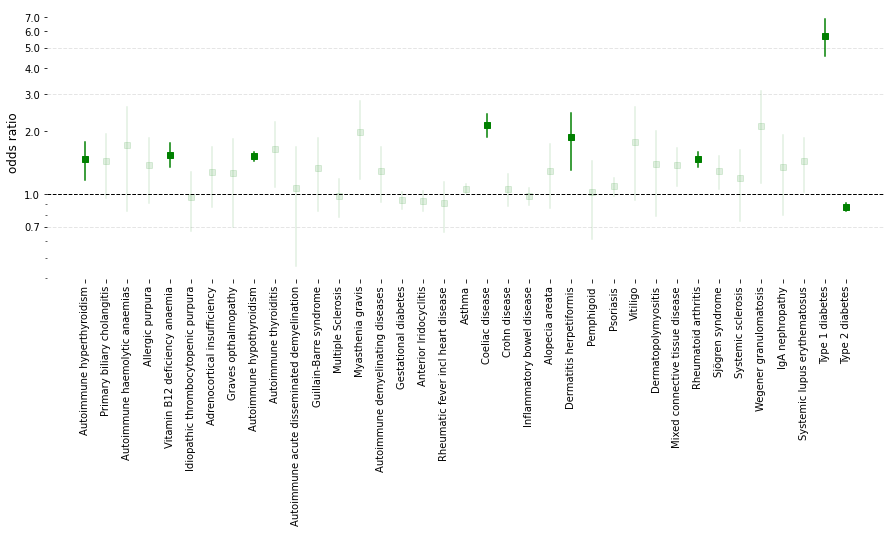

In [220]:
registry_res = pd.read_excel(res_dir+'summary_of_ADs.xlsx', sheet_name='registry_res')
eps_sig = plot_odds_ratio(registry_res, ['all', 'parent'])

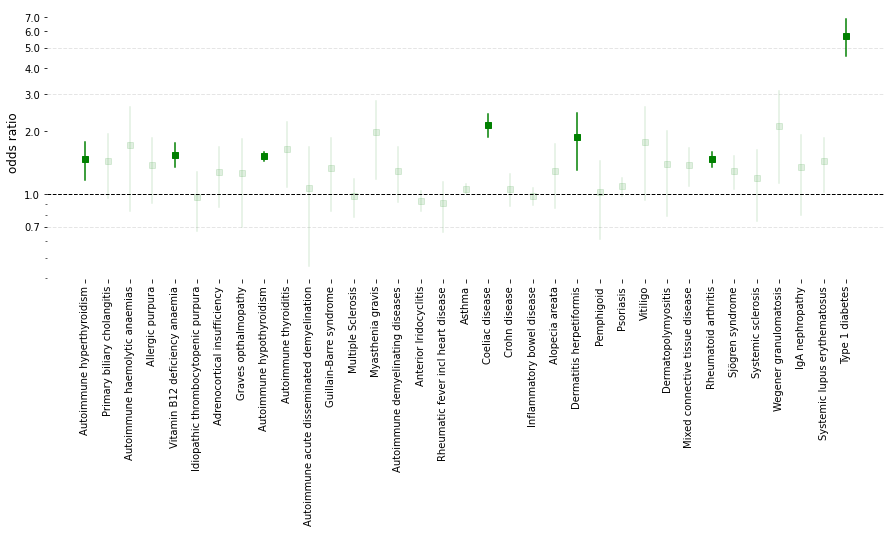

In [221]:
eps_exc = ['T2D', 'GEST_DIABETES']
eps_sig = plot_odds_ratio(registry_res[~registry_res.endpoint.isin(eps_exc)], ['all', 'parent'])

In [169]:
def process_crossed_data(dataset, note_who_1, note_who_2):
    """
    :param data: a DataFrame of summary statistics
    :param note_who: note - 'boy', 'girl'; who - 'father', 'mother', 'parent'
    :return: a DataFrame of processed summary statistics
    """
    df1 = dataset[(dataset.note == note_who_1[0]) & (dataset.who == note_who_1[1])][['endpoint',"pval", "hr_025", "hr_975", "se"]]
    df1 = df1.rename(columns={"pval": 'p_fa', "hr_025": 'lower_fa', "hr_975": 'upper_fa', "se": 'se_fa'})
    df2 = dataset[(dataset.note == note_who_2[0]) & (dataset.who == note_who_2[1])][['endpoint',"pval", "hr_025", "hr_975", "se"]]
    df2 = df2.rename(columns={"pval": 'p_mo', "hr_025": 'lower_mo', "hr_975": 'upper_mo', "se": 'se_mo'})
    df1 = df1.merge(df2, 'outer', on='endpoint')

    df1['hr_fa'] = (df1.lower_fa + df1.upper_fa) / 2
    df1['hr_mo'] = (df1.lower_mo + df1.upper_mo) / 2
    df1['hr_test'] = (df1.hr_fa - df1.hr_mo) / np.sqrt(df1.se_fa ** 2 + df1.se_mo ** 2)  # t-test
    df1['hr_p'] = 2 * norm.cdf(-np.abs(df1.hr_test))
    df1['hr_significant'] = [True if i < 0.05 / len(df1) else False for i in df1.hr_p]

    return df1


def plot_crossed_odds_ratio(dataset, axes, color, ticks, outcome='T1D_STRICT'):
    """
    :param dataset: a DataFrame of precessed summary statistics
    :param axes: a list which indicates the names of axes
    :param color: a string which indicates the color of the plot
    :param ticks: a list which indicates the markers denoting data points on axes
    :param outcome: a string which indicates the outcome disease name
    :return: a odds ratio plot of the diseases by groups
    """
    plt.figure(figsize=(7, 7))
    plt.box(False)
#     plt.title(note, size=16)
    plt.xlabel(axes[0], size=12)
    plt.ylabel(axes[1], size=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.xlim([ticks[0], ticks[-1]])
    plt.ylim([ticks[0], ticks[-1]])
    plt.plot([ticks[0], ticks[-1]], [ticks[0], ticks[-1]], color='lightgrey', linestyle='--', linewidth=1)
    for _, row in dataset.iterrows():
        x, y = row.hr_fa, row.hr_mo
        if row.hr_significant:
            alpha = 1
            if row.endpoint != 'M13_RHEUMA':
                plt.annotate(eps_dict[row.endpoint], (x*1.05, y*0.92), size=12)
            else:
                plt.annotate(eps_dict[row.endpoint], (x*1.05, y*1.05), size=12)
        else:
            alpha = .08
        plt.plot(x, y, 's', color=color, alpha=alpha)
        plt.plot((row.lower_fa, row.upper_fa), (y, y), color=color, alpha=alpha)
        plt.plot((x, x), (row.lower_mo, row.upper_mo), color=color, alpha=alpha)
    ax = plt.gca()
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.get_yaxis().set_major_formatter(ScalarFormatter())
    plt.grid(alpha=.5)
    plt.show()

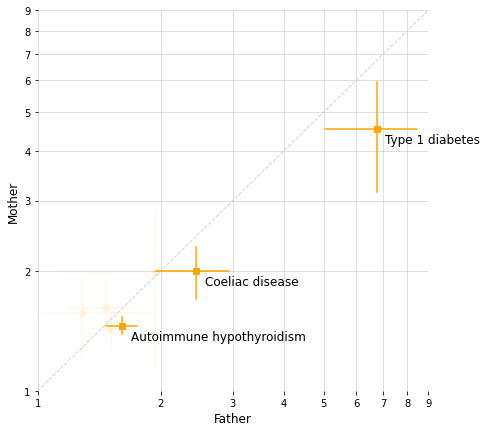

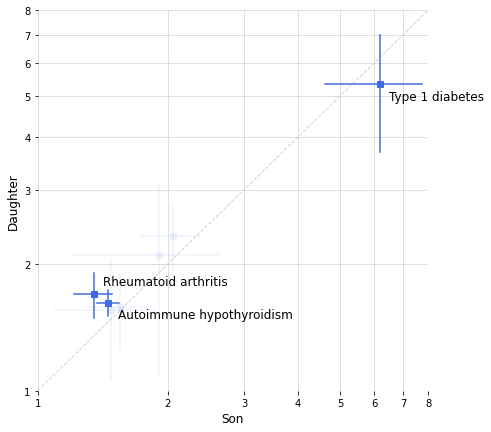

In [202]:
data_for_plot1 = process_crossed_data(registry_res[registry_res.endpoint.isin(eps_sig)], 
                                      ['all', 'father'], ['all', 'mother'])
data_for_plot2 = process_crossed_data(registry_res[registry_res.endpoint.isin(eps_sig)], 
                                      ['son', 'parent'], ['daughter', 'parent'])
plot_crossed_odds_ratio(data_for_plot1, ['Father', 'Mother'], 'orange', list(range(1,10)))
plot_crossed_odds_ratio(data_for_plot2, ['Son', 'Daughter'], 'royalblue', list(range(1,9)))

In [19]:
# process data for forest plot in r
sex_res = registry_res[registry_res.endpoint.isin(eps_sig+['T1D_STRICT'])]
sex_res['group'] = sex_res.who+'-'+sex_res.note
sex_res['odds_ratio'] = (sex_res.hr_025+sex_res.hr_975)/2
sex_res['beta'] = np.log(sex_res.odds_ratio)
sex_res['pvalue'] = sex_res.pval
sex_res['name'] = [eps_dict[i] for i in sex_res.endpoint]
sex_res = sex_res[['name','group','odds_ratio','se','pvalue','hr_025','hr_975', 'beta']]
sex_res = sex_res[sex_res.group.isin(['parent-all', 'father-boy', 'father-girl', 'mother-boy','mother-girl'])]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher

In [159]:
sex_res = pd.read_excel(res_dir+'summary_of_ADs.xlsx', sheet_name='sex_res')
sex_res['group'] = sex_res.who + ' - ' + sex_res.note

choose colors via https://htmlcolorcodes.com/

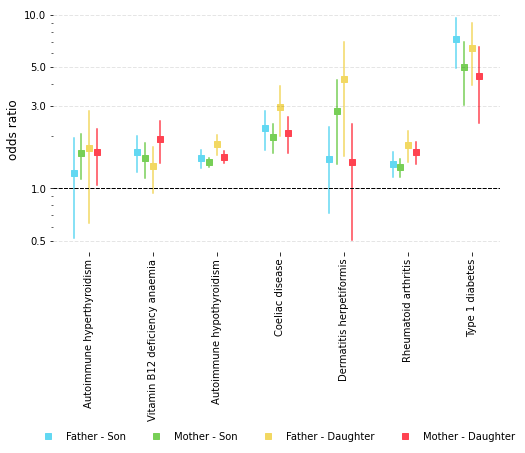

In [222]:
plt.figure(figsize=(8, 5))
plt.box(False)
plt.grid()
groups = sex_res.group.unique()
colors = ["#62D8F2", "#77CF56", "#F2D862", "#FF4351"]#['#FF4351', '#F4C035', '#8BD54A', '#31A1FF']
color_dict = dict(zip(groups, colors))
for i in range(len(eps_sig)):
    sub_res = sex_res[sex_res.endpoint == eps_sig[i]]
    shift = -0.24
    for pair in groups:
        or_025 = sub_res.loc[sub_res.group == pair, 'or_025'].values[0]
        or_975 = sub_res.loc[sub_res.group == pair, 'or_975'].values[0]
        plt.plot((i+shift, i+shift), (or_025, or_975), color=color_dict[pair])
        if i == 0:
            plt.plot(i+shift, (or_025+or_975)/2, 's', color=color_dict[pair], label=pair)
        else:
            plt.plot(i+shift, (or_025+or_975)/2, 's', color=color_dict[pair])
        shift += 0.12

plt.xticks(range(len(eps_sig)), [eps_dict[i] for i in eps_sig], rotation=90)
plt.ylabel('odds ratio', size=12)
plt.axhline(y=1.0, color='black', linestyle='--', linewidth=1)

plt.yscale('log')
scales = [.5, 1, 3, 5, 10]
plt.yticks(scales)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(ScalarFormatter())
for i in scales:
    alpha = 1 if i==1 else 0.1
    plt.axhline(y=i, color='black', linestyle='--', linewidth=1, alpha=alpha)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.7), ncol=4, frameon=False)
plt.grid()
plt.show()

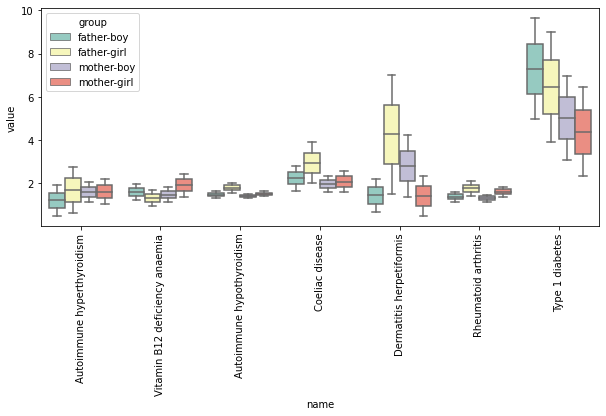

In [38]:
sex_res_for_test = sex_res[sex_res.group != 'parent-all']
sex_res_for_test = pd.melt(sex_res_for_test, id_vars=['name', 'group'], value_vars=['odds_ratio', 'hr_025', 'hr_975'])[['name','group','value']]
plt.figure(figsize=(10, 4))
sns.boxplot(x='name', y='value', hue='group', data=sex_res_for_test, palette="Set3")
plt.xticks(rotation=90)
plt.show()

In [152]:
def plot_comparisons(df, outcome='T1D_STRICT', plt_len=15):
    """
    :param df: a DataFrame of summary statistics
    :param plt_len: an integer which indicates the length of plot
    :param outcome: a string which indicates the outcome disease name
    :return: a odds ratio plot of all the diseases in the list
    """
    df = df.sort_values(by='endpoint')
    df.index = range(len(df))
    fig, (ax2,ax1) = plt.subplots(nrows=2, sharex=True, figsize=(plt_len, 5), subplot_kw=dict(frameon=False)) # frameon=False removes frames
    plt.subplots_adjust(hspace=.5)
    for i, row in df.iterrows():
        alpha_rg = 1 if row.p_rg <= 0.05 / len(df) else 0.12
        alpha_hr = 1 if row.p_hr <= 0.05 / len(df) else 0.12
        ax1.plot((i, i), (row.rg_025, row.rg_975), color='tomato', alpha=alpha_rg)
        ax1.plot(i, (row.rg_025+row.rg_975)/2, 's', color='tomato', alpha=alpha_rg)
        ax2.plot((i, i), (row.hr_025, row.hr_975), color='green', alpha=alpha_hr)
        ax2.plot(i, (row.hr_025+row.hr_975)/2, 's', color='green', alpha=alpha_hr)
    ax1.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
    ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=1)
#     ax2.set_yticks([.5, 1.0,2.0,3.0])
    plt.xticks(range(len(df)), [eps_dict[i] for i in df.endpoint.tolist()], rotation=90)
    ax1.set_ylabel('Genetic correlation', size=12)
    ax2.set_ylabel('Registry-based odds ratio', size=12)
    plt.show()


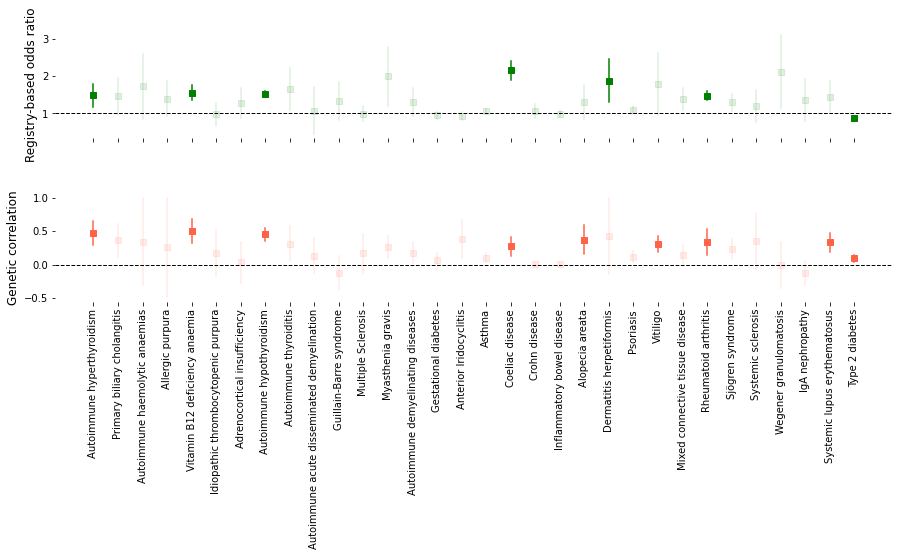

In [251]:
res1 = stat_df[['ep2', 'rg_025', 'rg_975', 'p']].rename(columns={'ep2': 'endpoint', 'p': 'p_rg'})
res1['rg_975'] = np.where(res1.rg_975>1, 1, res1.rg_975)
res2 = registry_res[(registry_res.note == 'all')&(registry_res.who == 'parent')]
res2 = res2[['endpoint', 'pval', 'hr_025', 'hr_975']].rename(columns={'pval':'p_hr'})
res = res1.merge(res2, 'left', on='endpoint')
plot_comparisons(res)

In [149]:
rg_res = stat_df[['ep2', 'p', 'rg_025', 'rg_975']]
rg_res['rg_975'] = np.where(rg_res.rg_975>1, 1, rg_res.rg_975)
rg_res.columns = ['endpoint', 'pval', 'hr_025', 'hr_975']
hla_prs_res = pd.read_excel(res_dir+'summary_of_ADs.xlsx', sheet_name='hla_prs_res_')
hla_prs_res['hr_025'] = np.log(hla_prs_res.hr_025)
hla_prs_res['hr_975'] = np.log(hla_prs_res.hr_975)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [223]:
def plot_association(df, sig_eps, ylabel, color, hline, outcome='T1D_STRICT', plt_len=15, log_scale={}):
    """
    :param results: a DataFrame of summary statistics
    :param outcome: a string which indicates the outcome disease name
    :return: a odds ratio plot of all the diseases in the list
    """
    df = df.sort_values(by='endpoint')
    df.index = range(len(df))
    plt.figure(figsize=(plt_len, 5))
    plt.box(False)
    plt.grid()
    for i, row in df.iterrows():
        alpha = 1 if row.pval <= 0.05 / len(df) else 0.12
        plt.plot((i, i), (row.hr_025, row.hr_975), color=color, alpha=alpha)
        plt.plot(i, (row.hr_025+row.hr_975)/2, 's', color=color, alpha=alpha)
        if row.endpoint in sig_eps:
            plt.annotate('$', (i+.1, row.hr_975+.01), size=12, color='green')

    plt.xticks(range(len(df)), [eps_dict[i] for i in df.endpoint.tolist()], rotation=90)
    plt.ylabel(ylabel, size=12)
    plt.axhline(y=hline, color='black', linestyle='--', linewidth=1)
    
    if log_scale:
        plt.yscale('log')
        plt.yticks(log_scale['scales'])
        ax = plt.gca()
        ax.get_yaxis().set_major_formatter(ScalarFormatter())
        for each in log_scale['lines']:
            plt.axhline(y=each, color='black', linestyle='--', linewidth=1, alpha=0.08)
    
    plt.grid()
    plt.show()

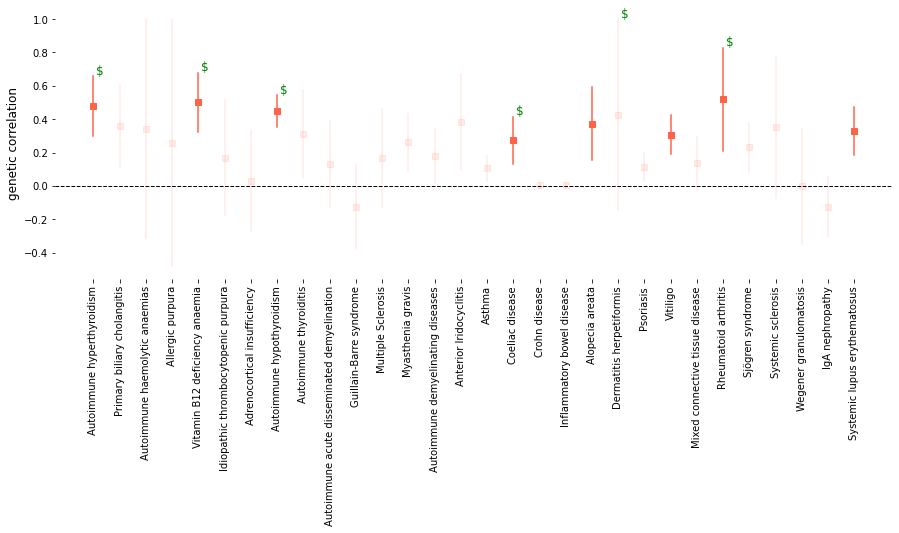

In [224]:
plot_association(rg_res[~rg_res.endpoint.isin(eps_exc)], eps_sig, 'genetic correlation', 'tomato', 0)

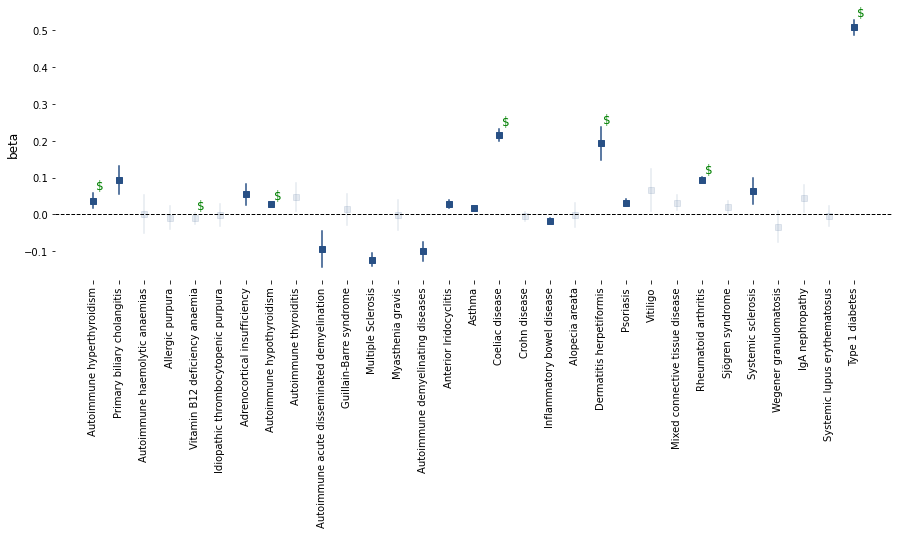

In [70]:
plot_association(hla_prs_res[~hla_prs_res.endpoint.isin(eps_exc)], eps_sig, 'beta', '#285085', 0)#, log_scale={'scales':[-0.1,0,0.1,0.3,0.5], 'lines':[-0.1, 0.5]})

In [149]:
def plot_association(df, sig_eps, ylabel, color, hline, outcome='T1D_STRICT', plt_len=15):
    """
    :param results: a DataFrame of summary statistics
    :param outcome: a string which indicates the outcome disease name
    :return: a odds ratio plot of all the diseases in the list
    """
    df = df.sort_values(by='endpoint')
    df.index = range(len(df))
    fig,(ax1,ax2) = plt.subplots(2, 1, sharex=True, figsize=(plt_len, 5), gridspec_kw={'height_ratios': [2, 5]})
    fig.subplots_adjust(hspace=0.05)  # adjust space between axes
    plt.grid()
    for i, row in df.iterrows():
        alpha = 1 if row.pval <= 0.05 / len(df) else 0.12
        ax1.plot((i, i), (row.hr_025, row.hr_975), color=color, alpha=alpha)
        ax1.plot(i, (row.hr_025+row.hr_975)/2, 's', color=color, alpha=alpha)
        ax2.plot((i, i), (row.hr_025, row.hr_975), color=color, alpha=alpha)
        ax2.plot(i, (row.hr_025+row.hr_975)/2, 's', color=color, alpha=alpha)
        if row.endpoint in sig_eps:
            ax1.annotate('$', (i+.1, row.hr_975+.01), size=12, color='green')
            ax2.annotate('$', (i+.1, row.hr_975+.01), size=12, color='green')

    ax1.set_ylim(1.55,1.75)
    ax2.set_ylim(0.75,1.25)
    
    # hide the spines between ax and ax2
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()


    ax2.set_xticklabels([eps_dict[i] for i in df.endpoint.tolist()], rotation=90)
    ax2.set_ylabel(ylabel, size=12)
    ax2.axhline(y=hline, color='black', linestyle='--', linewidth=1)
    
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    plt.box(False)
    plt.grid()
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


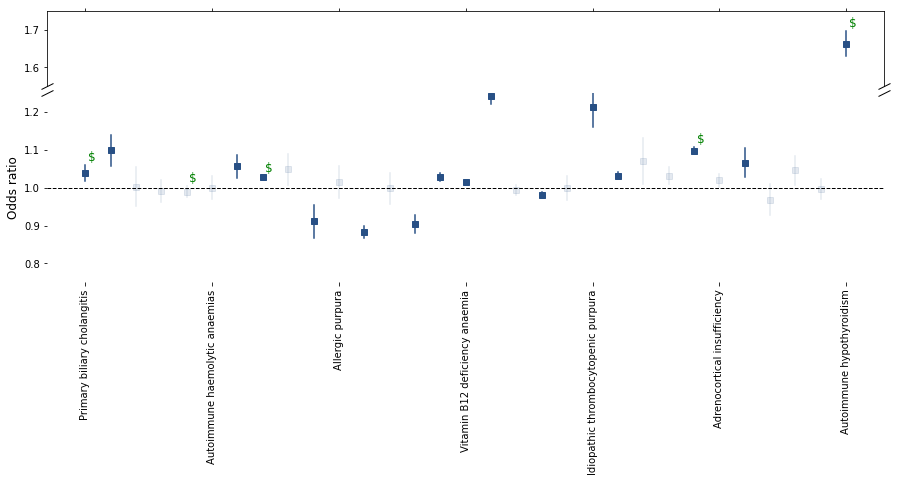

In [150]:
plot_association(hla_prs_res[~hla_prs_res.endpoint.isin(eps_exc)], eps_sig, 'Odds ratio', '#285085', 1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


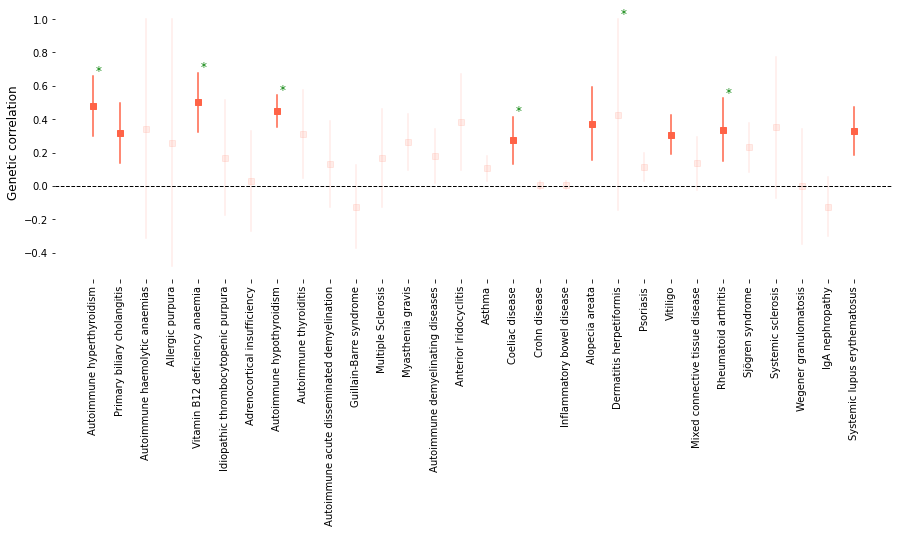

In [74]:
rg_res = stat_df[['ep2', 'p', 'rg_025', 'rg_975']]
rg_res['rg_975'] = np.where(rg_res.rg_975>1, 1, rg_res.rg_975)
rg_res.columns = ['endpoint', 'pval', 'hr_025', 'hr_975']
plot_association(rg_res[~rg_res.endpoint.isin(eps_exc)], eps_sig, 'Genetic correlation', 'tomato', 0)

In [172]:
# eps_sig = ['AUTOIMMUNE_HYPERTHYROIDISM','D3_ANAEMIA_B12_DEF','E4_HYTHY_AI_STRICT','K11_COELIAC','L12_DERMATHERP','M13_RHEUMA']
res1 = stat_df[['ep2', 'rg_025', 'rg_975', 'p', 'rg']].rename(columns={'ep2': 'endpoint', 'p': 'p_rg'})
res1['rg_975'] = np.where(res1.rg_975>1, 1, res1.rg_975)
res2 = registry_res[(registry_res.note == 'all')&(registry_res.who == 'parent')]
res2 = res2[['endpoint', 'pval', 'hr_025', 'hr_975']].rename(columns={'pval':'p_hr'})
res = res1.merge(res2, 'left', on='endpoint')
res['hr'] = (res.hr_025 + res.hr_975)/2

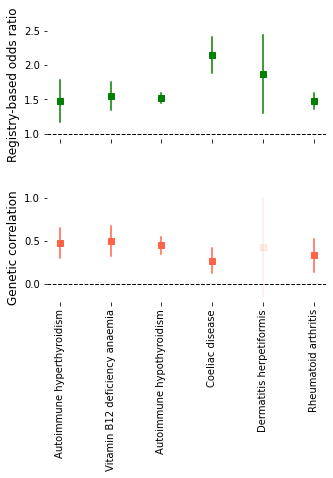

In [155]:
plot_comparisons(res[res.endpoint.isin(eps_sig)], plt_len=5)

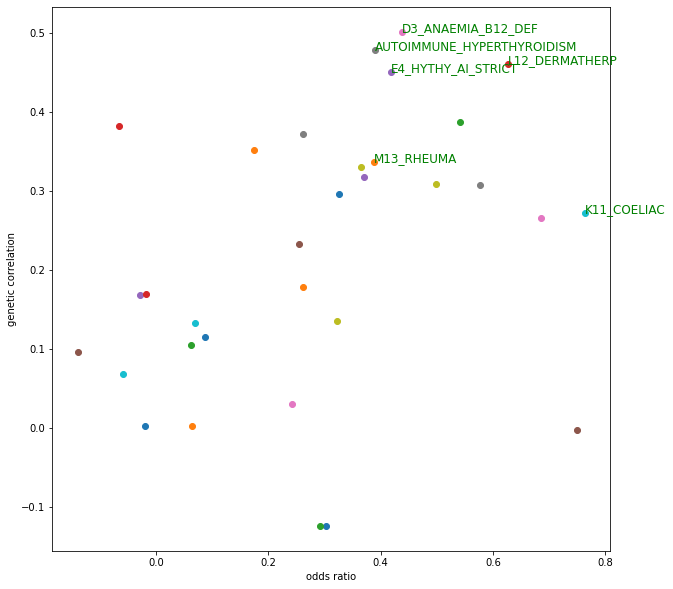

In [176]:
plt.figure(figsize=(10, 10))
for i, row in res.iterrows():
    plt.scatter(np.log(row.hr), row.rg)
    if row.endpoint in eps_sig:
        plt.annotate(row.endpoint, (np.log(row.hr), row.rg), size=12, color='green')
plt.xlabel('odds ratio')
plt.ylabel('genetic correlation')
plt.show()